## 67-364 Practical Data Science Final Project

### What Audio Features Make a Song Popular and What do the Music Markets Like in Songs?

### Members: Omar Qamar (omq) & Massa Coulibaly (mpcoulib)

### Motivation:

In this day and age, everyone is trying to optimize success. And the music industry is no different from this. Our idea for this project was sparked when we were discussing what it takes to make a popular song and which region should we target it in marketing the song. That was our initial question. So we took as a scenario that Massa is trying to make a hit song. These questions came up:

1. What makes a song popular? 
2. How can we make the most popular song possible?
3. Which regions should Massa try to market his song at to maximize the popularity?

These questions were our initial thoughts we were trying to answer.

### What is Our Task?

We attempted to collect the audio features of a dataset of thousands of songs and attempted to analyze them. We looked into different music features of the songs that were popular and not popular. Then we tried to find correlations between any and all the music features of the songs to attempt to explain the qualities of the songs that made them more popular.

We followed the Data Science pipelines from start to end, including:

1. Data Collection
2. Data Cleaning and Processing
3. Data Analysis
4. Modeling
5. Main Findings/Results and Interpretation
6. Conclusion

Soon, we identified the needed tools of the pipeline. We learned we could use the Spotify Web API for Developers to begin the data collection. We would need to use Spotipy, a Python library that makes it easy to access the Spotify API. Below are the different libaries we imported to use in this project:

In [1]:
pip install spotipy

  Attempting uninstall: async-timeout
    Found existing installation: async-timeout 4.0.1
    Uninstalling async-timeout-4.0.1:
      Successfully uninstalled async-timeout-4.0.1
Note: you may need to restart the kernel to use updated packages.


Here we registered our application on Spotify and got API credentials to use to collect song data. Here are our Spotify Client ID, Client Secret, and Redirect URI

In [1]:
SPOTIPY_CLIENT_ID = "e6d5c397bf9349cc9194362437a8d6be"
SPOTIPY_CLIENT_SECRET = "b170d607d39a4a21855cf387ebfd0d88"
SPOTIPY_REDIRECT_URI = "http://localhost:7778/callback"

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo

from numpy import cov
from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import math
import warnings
import time
import pprint

warnings.filterwarnings("ignore", category=DeprecationWarning) 

Here we create an instance of the Spotify Web API connection to query data and get responses from the API in the form of songs and the audio features of each song. More on that later...

You can read more about the [Spotipy Python library](https://spotipy.readthedocs.io/en/2.21.0/) and the [Spotify Web API for Developers](https://developer.spotify.com/documentation/web-api/reference/#/).

In [3]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET,
    redirect_uri=SPOTIPY_REDIRECT_URI,
    scope="user-library-read"))

### First Data Collection and some Early Data Visualization/Analysis

In [4]:
#Code borrowed partially from [1], refer to appendices for more details

#The music audio features of our interest
ATTRIBUTES = ['danceability', 'energy', 'acousticness', 'speechiness', 'valence']

# This function takes a playlist of songs and collects a bunch of audio features, listed above, for that playlist
def playlist_audio_features_average(playlist):
    playlist_length = playlist['tracks']['total']
    
    #initialize a dictionary and list for the audio features of the playlist
    playlist_dict = dict()
    track_ids = []
    
    #set all the audio features for the songs as zero
    for key in ATTRIBUTES:
        playlist_dict[key] = 0
    
    #loop through the playlist paginations and add the track ids of each song in the playlist
    for track_pager in sp.playlist_tracks(playlist['id'])['items']:
        try:
            track_ids.append(track_pager['track']['id'])
        except:
            cheese = 0
    
    #loop through each song in the playlist and add the average of all the song audio features
    analysis = sp.audio_features(tracks=track_ids)
    for indiv_analysis in analysis:
        try:
            for key in indiv_analysis:
                if key in ATTRIBUTES:
                    playlist_dict[key] += indiv_analysis[key] / playlist_length
        except:
            cheese = 0
    
    #loop through the playlist and round the audio features number to 3 decimal places
    for key in playlist_dict:
        playlist_dict[key] = round(playlist_dict[key], 3)

    return playlist_dict

#this function calls the above function, feeding it each individual playlist from the list of playlists
def get_graphing_data(playlists):
    data = [ATTRIBUTES]
    for playlist in playlists:
        data.append((playlists[playlist], playlist_audio_features_average(playlists[playlist])))
    return data


SPOTIFY_PLAYLISTS = []
for playlist in sp.featured_playlists()['playlists']['items']:
    SPOTIFY_PLAYLISTS.append(playlist)

#List of Top 10 Music Market Charts around the World
TOP_PLAYLIST_DICT = {
    'Global': sp.playlist('37i9dQZEVXbMDoHDwVN2tF'),
    'United States': sp.playlist('37i9dQZEVXbLRQDuF5jeBp'),
    'Japan': sp.playlist('37i9dQZEVXbKXQ4mDTEBXq'),
    'United Kingdom': sp.playlist('37i9dQZEVXbLnolsZ8PSNw'),
    'Germany': sp.playlist('37i9dQZEVXbJiZcmkrIHGU'),
    'France': sp.playlist('37i9dQZEVXbIPWwFssbupI'),
    'South Korea': sp.playlist('37i9dQZEVXbNxXF4SkHj9F'),
    'Canada': sp.playlist('37i9dQZEVXbKj23U1GF4IR'),
    'Australia': sp.playlist('37i9dQZEVXbJPcfkRz0wJ0'),
    'Italy': sp.playlist('37i9dQZEVXbIQnj7RRhdSX'),
}

MY_PLAYLIST_DICT = {
    'New': sp.playlist('1ShGu5VsGsiArDUlEly4DN')
}

all_charts_features = get_graphing_data(TOP_PLAYLIST_DICT)

Global_features = all_charts_features[1][1]
US_features = all_charts_features[2][1]
Japan_features = all_charts_features[3][1]
UK_features = all_charts_features[4][1]
Germany_features = all_charts_features[5][1]
France_features = all_charts_features[6][1]
SouthKorea_features = all_charts_features[7][1]
Canada_features = all_charts_features[8][1]
Australia_features = all_charts_features[9][1]
Italy_features = all_charts_features[10][1]

print("Finished collecting chart features!")

Finished collecting chart features!


In [7]:
#Code borrowed partially from [2], refer to the appendices for more details

#This function paginates through the playlist and collects all the track ids
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [8]:
#This function collects the details of the artist name, artist genres, song popularity, and excludes songs with missing data
#to pre-clean the dataset

def getsongartistdetails(tracks):
    track_ids = []

    for track in tracks:
        track_ids.append(track["track"]["id"])
    
    artist_ids = []

    for track in tracks:
        artist_ids.append(track["track"]["artists"][0]["id"])

    tracks_list_details = []
    for artist,track in zip(artist_ids, track_ids):
        song = sp.track(track)
        time.sleep(3)
        artisty = sp.artist(artist)
        time.sleep(3)
        details = {}
        details["artist_name"] = song["artists"][0]["name"]
        details["popularity"] = song["popularity"]
        try:
            details["genres"] = artisty["genres"][len(artisty["genres"])//2]
        except:
            details["genres"] = "Unknown"
        tracks_list_details.append(details)
    return tracks_list_details

We collected the genres, song popularity, and artists on three major charts on Spotify to gauge what genres of songs are most popular on Spotify depending on whether it is the Global Chart, the US Chart, or the Japanese Chart.

For each chart, in the interest of ease and to not lose access to the Spotify API by querying more than the daily limit, we saved the data into CSV files for multiple uses later. The code for collecting the playlists data is commented but still included in the notebooks in each respective cell

First we collected artist, song, and genre data from the Global Top 50 Chart on Spotify, re-collected and saved on November 9th, 2022 

In [9]:
#The data was re-collected on November 9th, 2022 and saved to a CSV file for ease and the interest of not losing API access
#global_tracks_details = getsongartistdetails(TOP_PLAYLIST_DICT["Global"]["tracks"]["items"])
#global_tracks_details_df = pd.DataFrame(global_tracks_details)
#global_tracks_details_df.to_csv('GlobalTracksDetails.csv', encoding='utf-8', index=False)

global_tracks_details_DF = pd.read_csv("GlobalTracksDetails.csv")
print("Successfully read CSV file!")

Successfully read CSV file!


Then we collected artist, song, and genre data from the US Top 50 Chart on Spotify, re-collected and saved on November 9th, 2022 

In [10]:
#The data was re-collected on November 9th, 2022 and saved to a CSV file for ease and the interest of not losing API access
#US_tracks_details = getsongartistdetails(TOP_PLAYLIST_DICT["United States"]["tracks"]["items"])
#US_tracks_details_df = pd.DataFrame(US_tracks_details)
#US_tracks_details_df.to_csv('USTracksDetails.csv', encoding='utf-8', index=False)

US_tracks_details_DF = pd.read_csv("USTracksDetails.csv")
print("Successfully read CSV file!")

Successfully read CSV file!


Then we collected artist, song, and genre data from the Japan Top 50 Chart, re-collected and saved on November 9th, 2022 

In [11]:
#The data was re-collected on November 9th, 2022 and saved to a CSV file for ease and the interest of not losing API access
#Japan_tracks_details = getsongartistdetails(TOP_PLAYLIST_DICT["Japan"]["tracks"]["items"])
#Japan_tracks_details_df = pd.DataFrame(Japan_tracks_details)
#Japan_tracks_details_df.to_csv('JapanTracksDetails.csv', encoding='utf-8', index=False)

Japan_tracks_details_DF = pd.read_csv("JapanTracksDetails.csv")
print("Successfully read CSV file!")

Successfully read CSV file!


Then we begin the early data analysis to gain insights from the Charts data we collected

First, we graphed the most popular music genres on the **Global Top 50** music chart on Spotify as of November 9th, 2022 (date of data recollection)

<AxesSubplot:xlabel='genres', ylabel='popularity'>

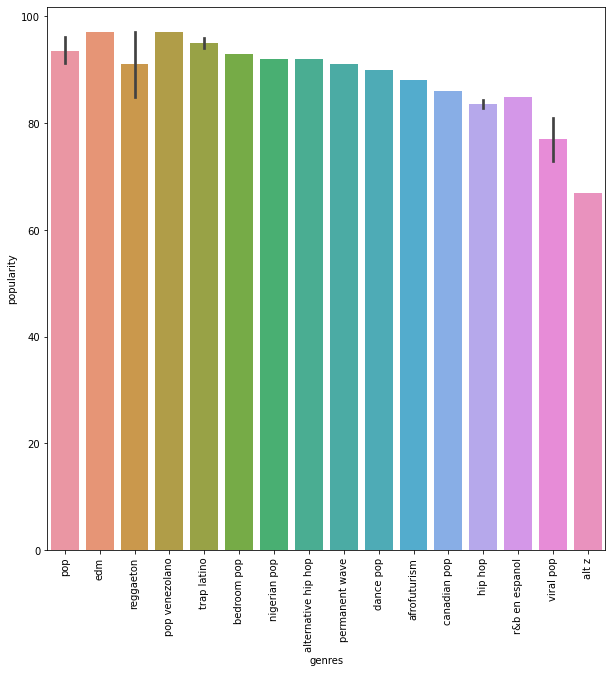

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='x', rotation=90)
sns.barplot(x=global_tracks_details_DF.sort_values(["popularity"], ascending=False).groupby(by="genres")["genres"].head(10), y=global_tracks_details_DF.groupby(by="genres")["popularity"].head(10))

Then we graphed the most popular music genres on the **US Top 50** music chart on Spotify as of November 9th, 2022 (date of data recollection)

<AxesSubplot:xlabel='genres', ylabel='popularity'>

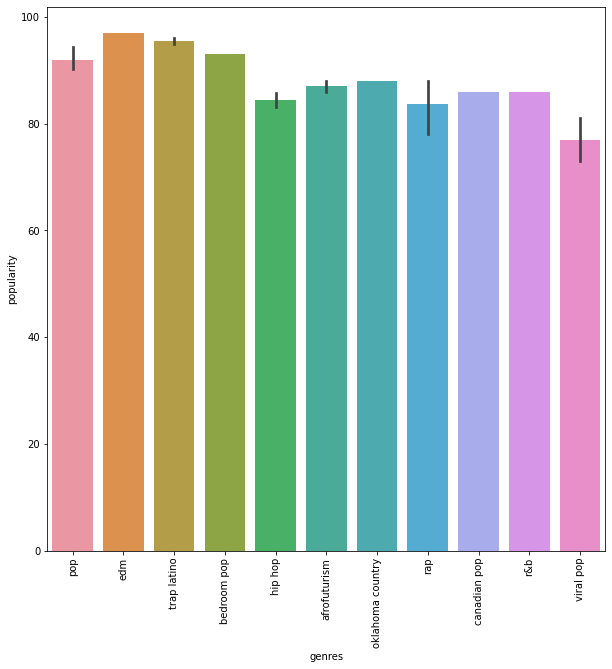

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='x', rotation=90)
sns.barplot(x=US_tracks_details_DF.sort_values(["popularity"], ascending=False).groupby(by="genres")["genres"].head(10), y=US_tracks_details_DF["popularity"])

Then we graphed the most popular music genres on the **Japanese Top 50** music chart on Spotify as of November 9th, 2022 (date of data recollection)

<AxesSubplot:xlabel='genres', ylabel='popularity'>

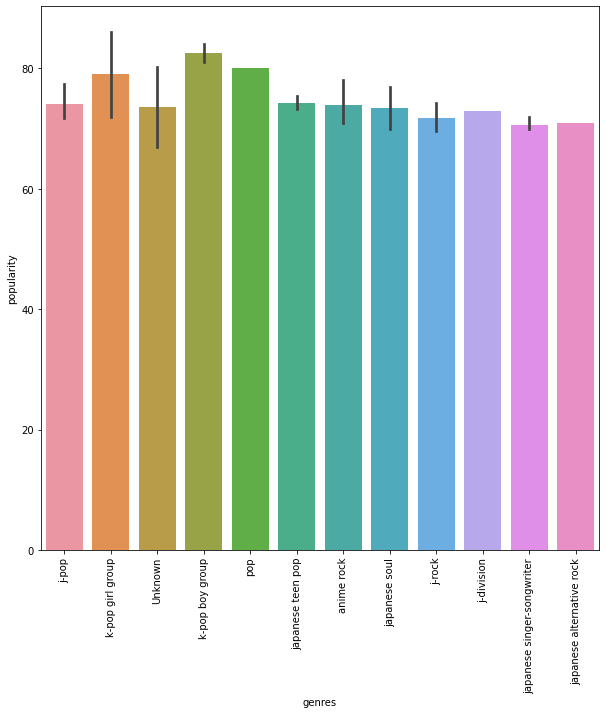

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='x', rotation=90)
sns.barplot(x=Japan_tracks_details_DF.sort_values(["popularity"], ascending=False).groupby(by="genres")["genres"].head(10), y=Japan_tracks_details_DF["popularity"])

In [21]:
#These functions are used to create the radar graphs used to assess the differences between the audio features of the
#songs on the Top 10 Spotify Charts in the world.

#this makes a single radar graph
def make_radar_chart(chart, title, name):
    categories = ['Danceability', 'Energy', 'Acousticness', 'Speechiness', 'Valence']
    categories = [*categories, categories[0]]
    
    chart_1 = list(chart.values())
    chart_1 = [*chart_1, chart_1[0]]
    
    fig = go.Figure(
        data=[
            go.Scatterpolar(r=chart_1, theta=categories, fill='toself', name=name)
        ],
        layout=go.Layout(
            title=go.layout.Title(text=title),
            polar={'radialaxis': {'visible': True}},
            showlegend=True
        )
    )
    return fig

#this makes two radar graphs for compare/contrast
def make_radar_chart_comparisontwo(chart1, chart2, title, names):
    categories = ['Danceability', 'Energy', 'Acousticness', 'Speechiness', 'Valence']
    categories = [*categories, categories[0]]

    chart_1 = list(chart1.values())
    chart_2 = list(chart2.values())
    chart_1 = [*chart_1, chart_1[0]]
    chart_2 = [*chart_2, chart_2[0]]


    fig = go.Figure(
        data=[
            go.Scatterpolar(r=chart_1, theta=categories, fill='toself', name=names[0]),
            go.Scatterpolar(r=chart_2, theta=categories, fill='toself', name=names[1])
        ],
        layout=go.Layout(
            title=go.layout.Title(text=title),
            polar={'radialaxis': {'visible': True}},
            showlegend=True
        )
    )

    return fig

#this makes three radar graphs for compare/contrast
def make_radar_chart_comparisonthree(chart1, chart2, chart3, title, names):
    categories = ['Danceability', 'Energy', 'Acousticness', 'Speechiness', 'Valence']
    categories = [*categories, categories[0]]

    chart_1 = list(chart1.values())
    chart_2 = list(chart2.values())
    chart_3 = list(chart3.values())
    chart_1 = [*chart_1, chart_1[0]]
    chart_2 = [*chart_2, chart_2[0]]
    chart_3 = [*chart_3, chart_3[0]]


    fig = go.Figure(
        data=[
            go.Scatterpolar(r=chart_1, theta=categories, fill='toself', name=names[0]),
            go.Scatterpolar(r=chart_2, theta=categories, fill='toself', name=names[1]),
            go.Scatterpolar(r=chart_3, theta=categories, fill='toself', name=names[2])
        ],
        layout=go.Layout(
            title=go.layout.Title(text=title),
            polar={'radialaxis': {'visible': True}},
            showlegend=True
        )
    )

    return fig


Then we begin graphing the audio features of the songs on the main music charts of the world.

First, we graph the *radar graph* of the **US Top 50** music chart on Spotify, as of November 9th (date of data recollection)

In [22]:
US_radar_chart = make_radar_chart(US_features, "US Chart Summary", "US Top 50 Chart")
US_radar_chart.show()

Then we graph the *radar graphs* of the **Japanese and South Korean Top 50** music charts on Spotify, as of November 9th (date of data recollection)

In [23]:
Asian_radar_chart = make_radar_chart_comparisontwo(Japan_features, SouthKorea_features, "Asian Charts Comparison", ["Japan Top 50", "South Korea Top 50"])
Asian_radar_chart

Then we graph the *radar graphs* of the **German, UK, and French Top 50** music charts on Spotify, as of November 9th (date of data recollection)

In [24]:
Europe_radar_chart = make_radar_chart_comparisonthree(Germany_features, UK_features, France_features, "Europe Charts Comparison", ["Germany Top 50", "UK Top 50", "France Top 50"])
Europe_radar_chart.show()

Then we graph the *radar graphs* of the **US, Japanese, and French Top 50** music charts on Spotify, as of November 9th (date of data recollection), to compare and contrast the three major charts of **North America, Asia, and Europe**

In [25]:
all_three_radar_chart = make_radar_chart_comparisonthree(US_features, Japan_features, France_features, "All Three Comparison", ["US Top 50", "Japan Top 50", "France Top 50"])
all_three_radar_chart.show()

The data collection continues!!

We soon realized that Spotify Web API for Developers provides audio features for each song on their platform. This was brilliant!

This way we could collect this data to analyze and attempt to gain insights about what audio features play a role in song 
popularity and what was the weight of this feature's role. The Wed API documentation page [4] gives a short description for each audio features, and their definitions are as follows:

1. **danceability**: a measure of how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
2. **energy**: a measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
3. **key**: the key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
4. **loudness**: a measure of the loudness of a track in decibels (dB), averaged over across the entire track. Values typically range between -60 and 0 db.
5. **mode**: a measure of the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
6. **speechiness**: a measure of the presence of spoken words in a track. Values above 0.66 describe tracks that are probably made entirely of spoken words, values between 0.33 and 0.66 describe tracks that may contain both music and speech, like rap music, and values below 0.33 represent music and other non-speech-like tracks.
7. **instrumentalness**: a measure of how much a track contains no vocals. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
8. **liveness**: a measure of the presence of an audience in the recording. A value above 0.8 provides strong likelihood that the track is live.
9. **valence**: a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
10. **tempo**: a measure of the estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

...on top of this we collected some other details about the songs in the large playlist such as *artist name, album name, track name & id, release date, and song popularity*.

**Song popularity** can be defined as :

a measure of how popular a song is relative to other songs on the platform, calculated by the number of recent streams. It goes from 0 to 100, 0 being very unpopular and 100 being most popular.

You can read more about the [song audio features here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)

In [26]:
#Code partially borrowed from [4], refer to the appendices for more information

#This function below collects the following details based on a given playlist: artist name, album name, track name, track id
#release date, popularity, and the audio features of each song: danceability, energy, key, loudness, mode, speechiness, 
#instrumentalness, liveness, valence, tempo, duration (ms), time signature

def analyze_playlist(creator, playlist_id, tracks):
    
    # Create empty dataframe
    playlist_features_list = ["artist","album","track_name","track_id","release_date","popularity","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    for track in tracks:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        try:
            i = 1
            if (len(track["track"]["album"]["artists"]) == 1):
                playlist_features["artist"] = track["track"]["artists"][0]["name"]
            elif (len(track["track"]["album"]["artists"]) > 1):
                playlist_features["artist"] = track["track"]["artists"][0]["name"]
                while(i < len(track["track"]["artists"])):
                    playlist_features["artist"] = playlist_features["artist"] + ", " + track["track"]["artists"][i]["name"]
                    i += 1
            playlist_features["album"] = track["track"]["album"]["name"]
            playlist_features["track_name"] = track["track"]["name"]
            playlist_features["track_id"] = track["track"]["id"]
            playlist_features["release_date"] = track["track"]["album"]["release_date"][0:4]
            playlist_features["popularity"] = track["track"]["popularity"]
        except:
            continue
        
        # Get audio features
        try:
            audio_features = sp.audio_features(playlist_features["track_id"])[0]
            for feature in playlist_features_list[6:]:
                playlist_features[feature] = audio_features[feature]
        except:
            continue
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

Again, in the interest of ease and to not lose access to the Spotify API by querying more than the daily limit, we saved the data into CSV files for multiple uses later. The code for collecting the playlists data is commented but still included in the notebooks in each respective cell

We collected the above mentioned data from a 10,000 song playlist (the maximum number of songs on a playlist), re-collected and saved on November 7th, 2022

The code that queried and collected then saved the above mentioned data was run previously and is now commented for credits sake

In [27]:
#This code was run early and collected 10,000 songs. They were then saved for ease into the CSV file called SpotifySongsDataset
#playlist_creator = "Willis Orr"
#playlist_id = "5S8SJdl1BDc0ugpkEvFsIL"

#all_tracks = get_playlist_tracks(playlist_creator, playlist_id)
#len(all_tracks)

#playlist_df = analyze_playlist(playlist_creator, playlist_id, all_tracks)
#playlist_df.shape

#playlist_df.to_csv('SpotifySongsDataset.csv', encoding='utf-8', index=False)
playlist_df = pd.read_csv("SpotifySongsDataset.csv")
print("Successfully read CSV file!")

Successfully read CSV file!


### Exploratory Analysis

Then we run some exploratory code to view this data.

First we see how many of the 10,000 song playlist passed our collecting filters (collecting only songs available to all charts)

In [28]:
playlist_df.shape

(9961, 18)

Then we check to see if the data contains Nan or Null values, meaning it requires cleaning and pre-processing.

In [49]:
playlist_df.isnull().sum()

artist              1
album               1
track_name          1
track_id            0
release_date        0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

Then we decide to see some descriptive statistics on this 9,961 song dataset.

In [29]:
playlist_df.describe()

release_date   popularity  danceability       energy          key  \
count   9961.000000  9961.000000   9961.000000  9961.000000  9961.000000   
mean    2007.907841    32.209718      0.567800     0.651601     5.227186   
std       23.201924    28.184848      0.166121     0.225258     3.585934   
min        0.000000     0.000000      0.000000     0.000000     0.000000   
25%     2005.000000     0.000000      0.467000     0.510000     2.000000   
50%     2012.000000    36.000000      0.581000     0.696000     5.000000   
75%     2016.000000    58.000000      0.686000     0.829000     8.000000   
max     2021.000000    92.000000      0.980000     1.000000    11.000000   

          loudness         mode  speechiness  instrumentalness     liveness  \
count  9961.000000  9961.000000  9961.000000       9961.000000  9961.000000   
mean     -7.693564     0.654151     0.069461          0.099226     0.184909   
std       4.439375     0.475668     0.074680          0.246149     0.153771   
min     -53.436000     0.000000     0.000000          0.000000     0.000000   
25%      -9.158000     0.000000     0.034000          0.000000     0.094000   
50%      -6.512000     1.000000     0.044000          0.000034     0.122000   
75%      -4.884000     1.000000     0.069600          0.008950     0.226000   
max      -0.276000     1.000000     0.957000          0.999000     0.988000   

           valence        tempo   duration_ms  time_signature  
count  9961.000000  9961.000000  9.961000e+03     9961.000000  
mean      0.472934   120.467378  2.832725e+05        3.934645  
std       0.248978    28.203590  3.687464e+05        0.352907  
min       0.000000     0.000000  1.001720e+05        0.000000  
25%       0.274000    99.961000  1.979360e+05        4.000000  
50%       0.468000   119.972000  2.249070e+05        4.000000  
75%       0.670000   138.014000  2.635600e+05        4.000000  
max       0.990000   240.107000  6.000661e+06        5.000000

Then we decide to see the spread or distribution of our collected dataset of our 9,961 songs.

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Popularity Distribution')

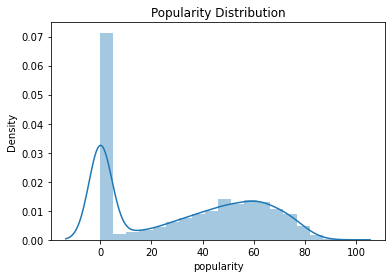

In [30]:
sns.distplot(playlist_df['popularity']).set_title('Popularity Distribution')

We can see many songs of our dataset are 0 popularity songs...but how much percentage of it exactly...

In [31]:
print("The percentage of 0 popularity songs in the dataset is:", (len(playlist_df[playlist_df["popularity"] == 0])/len(playlist_df))*100)

The percentage of 0 popularity songs in the dataset is: 34.19335408091557


In [32]:
playlist_df.sort_values(by="popularity", ascending = False).head(5)

artist                     album  \
1016        The Neighbourhood               I Love You.   
3306    Billie Eilish, Khalid      lovely (with Khalid)   
2811  Calvin Harris, Dua Lipa  One Kiss (with Dua Lipa)   
9191                   Eminem           The Eminem Show   
2585                 Coldplay                Parachutes   

                    track_name                track_id  release_date  \
1016           Sweater Weather  2QjOHCTQ1Jl3zawyYOpxh6          2013   
3306      lovely (with Khalid)  0u2P5u6lvoDfwTYjAADbn4          2018   
2811  One Kiss (with Dua Lipa)  7ef4DlsgrMEH11cDZd32M6          2018   
9191                Without Me  7lQ8MOhq6IN2w8EYcFNSUk          2002   
2585                    Yellow  3AJwUDP919kvQ9QcozQPxg          2000   

      popularity  danceability  energy  key  loudness  mode  speechiness  \
1016          92         0.612   0.807   10    -2.810     1       0.0336   
3306          88         0.351   0.296    4   -10.109     0       0.0333   
2811          88         0.791   0.862    9    -3.240     0       0.1100   
9191          88         0.908   0.669    7    -2.827     1       0.0738   
2585          88         0.429   0.661   11    -7.227     1       0.0281   

      instrumentalness  liveness  valence    tempo  duration_ms  \
1016          0.017700    0.1010    0.398  124.053       240400   
3306          0.000000    0.0950    0.120  115.284       200186   
2811          0.000022    0.0814    0.592  123.994       214847   
9191          0.000000    0.2370    0.662  112.238       290320   
2585          0.000121    0.2340    0.285  173.372       266773   

      time_signature  
1016               4  
3306               4  
2811               4  
9191               4  
2585               4

As we can see, three of the most popular songs on our dataset are from before 2014, more than **8 years old**!!

And the data analysis continues!!

We began by plotting each of the song audio feature or data against popularity for two reasons:

1. To begin understanding the correlation between these song audio features and popularity, if any
2. To help us decide which song audio features and details are important for inclusion in the modelling later on

First, we plot the date of the release dates and popularity to see what release years have currently more popular songs.

(-0.04918474501846398, 9.050665531628332e-07)

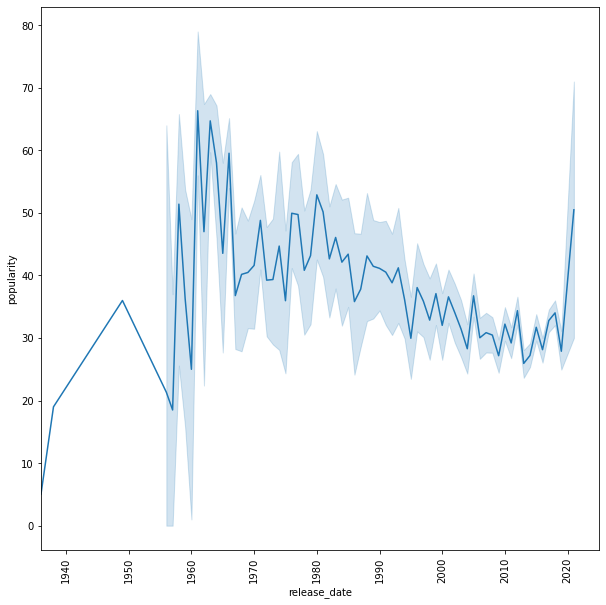

In [33]:
ig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='x', rotation=90)
ax.set_xlim(1936,2025)
sns.lineplot(x=playlist_df["release_date"],y=playlist_df["popularity"])
pearsonr(playlist_df["release_date"], playlist_df["popularity"])

Then, we plot the danceability of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.1072603942224813, 6.991587491054057e-27)

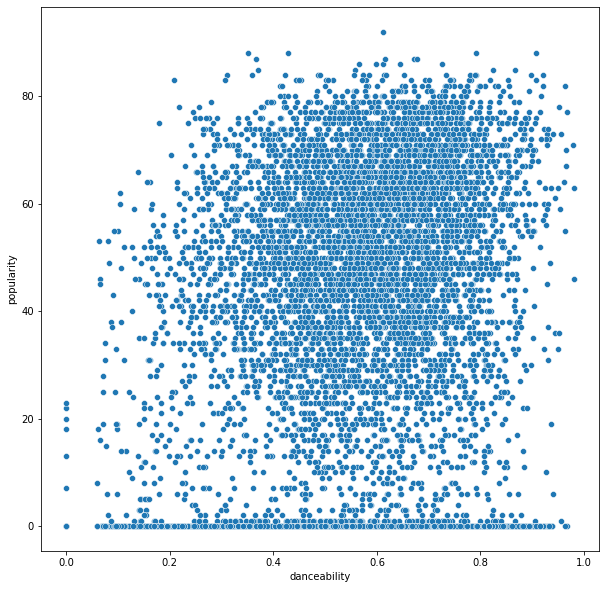

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["danceability"],playlist_df["popularity"])
pearsonr(playlist_df["danceability"], playlist_df["popularity"])

Then, we plot the energy of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.120434955140477, 1.6683633677884804e-33)

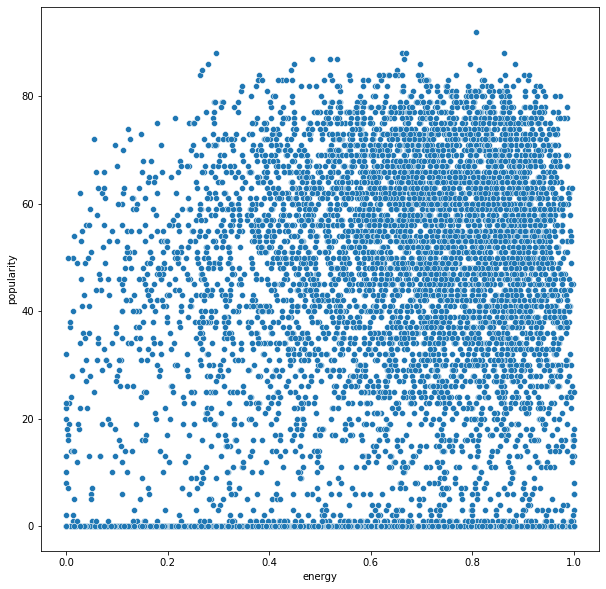

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["energy"],playlist_df["popularity"])
pearsonr(playlist_df["energy"], playlist_df["popularity"])

Then, we plot the key of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

<AxesSubplot:xlabel='key', ylabel='popularity'>

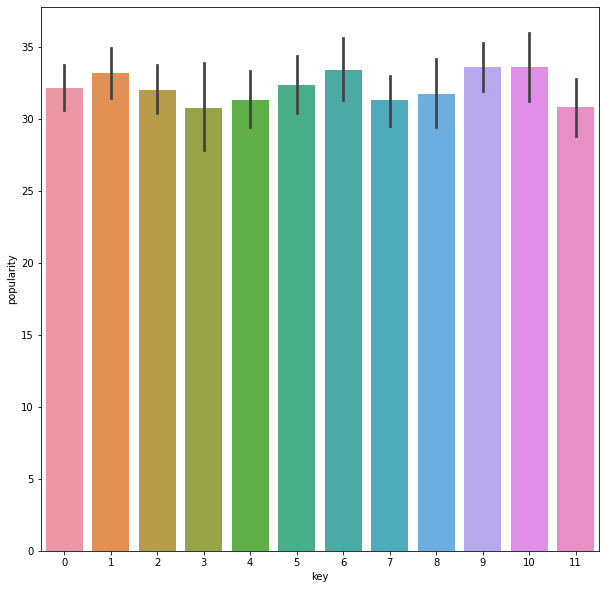

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=playlist_df["key"], y=playlist_df["popularity"])

Then, we plot the loudness of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.1787583345809986, 2.6129966646925766e-72)

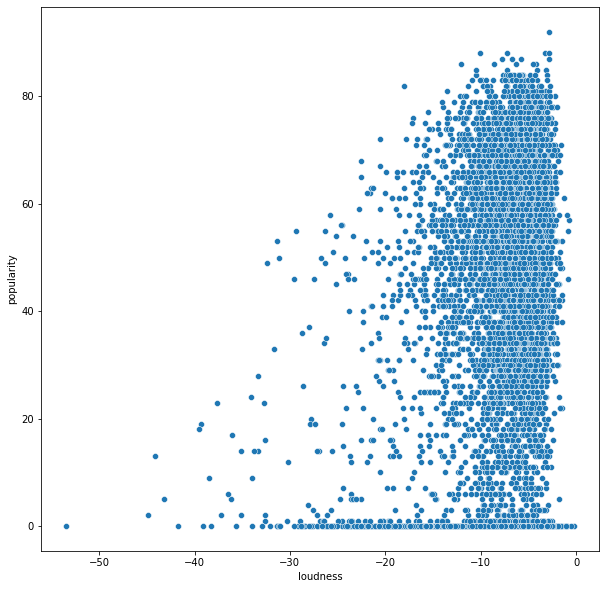

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["loudness"],playlist_df["popularity"])
pearsonr(playlist_df["loudness"], playlist_df["popularity"])

Then, we plot the speechiness of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.002062865829700722, 0.8369015897986846)

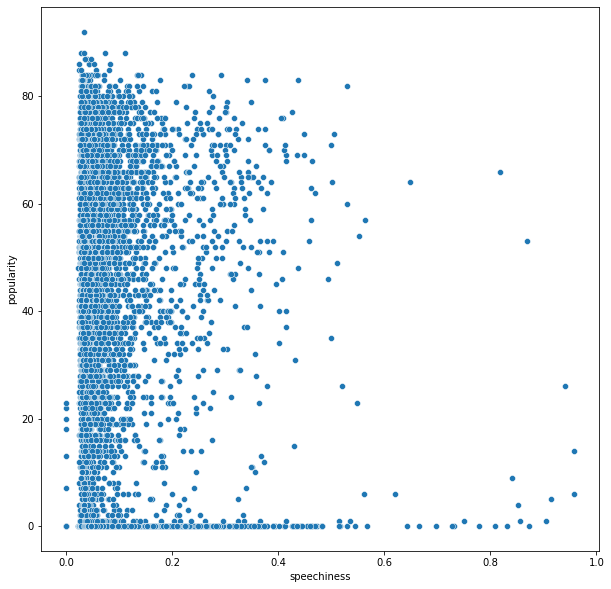

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["speechiness"],playlist_df["popularity"])
pearsonr(playlist_df["speechiness"], playlist_df["popularity"])

Then, we plot the instrumentalness of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(-0.18378954980953918, 2.1205778981490304e-76)

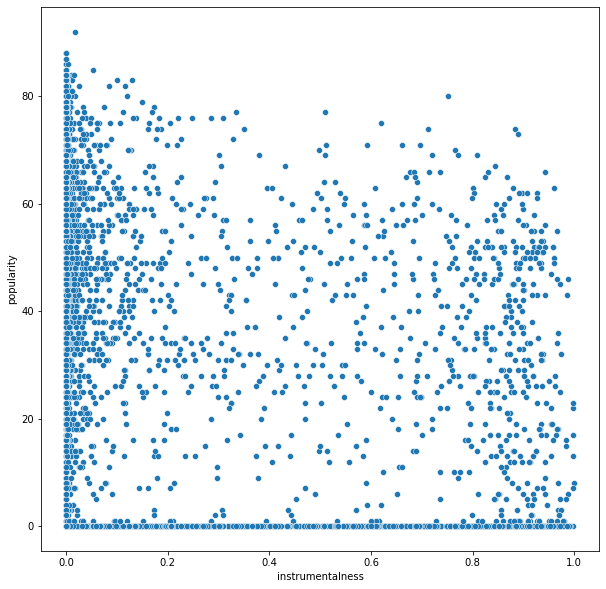

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["instrumentalness"],playlist_df["popularity"])
pearsonr(playlist_df["instrumentalness"], playlist_df["popularity"])

Then, we plot the liveness of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(-0.03302583861913462, 0.0009785472713718965)

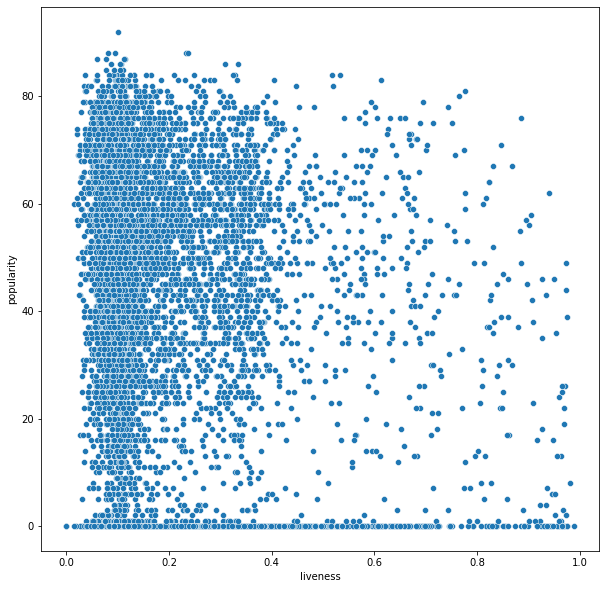

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["liveness"],playlist_df["popularity"])
pearsonr(playlist_df["liveness"], playlist_df["popularity"])

Then, we plot the valence of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.13829142489971866, 1.0026009821261065e-43)

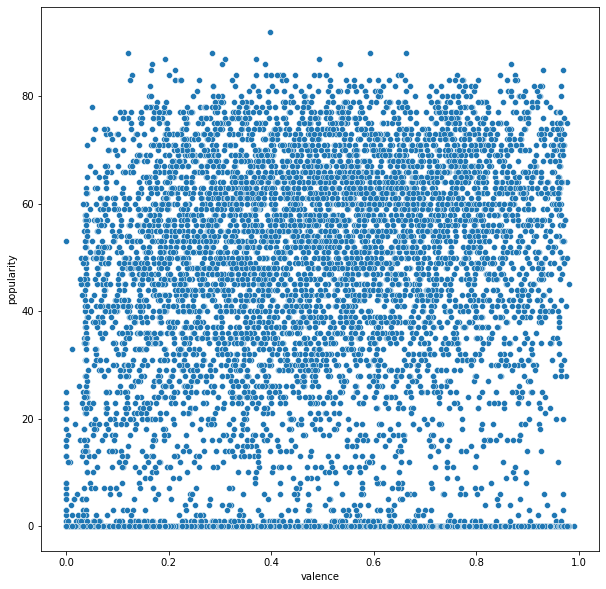

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["valence"],playlist_df["popularity"])
pearsonr(playlist_df["valence"], playlist_df["popularity"])

Then, we plot the tempo of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.029979716766147014, 0.002767779302449703)

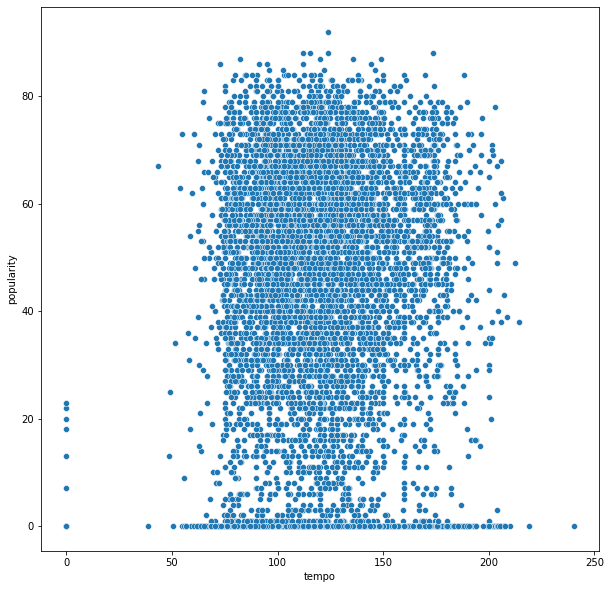

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["tempo"],playlist_df["popularity"])
pearsonr(playlist_df["tempo"], playlist_df["popularity"])

Then, we plot the duration (ms) of the songs and song popularity to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(-0.11481818656329364, 1.3816393869742124e-30)

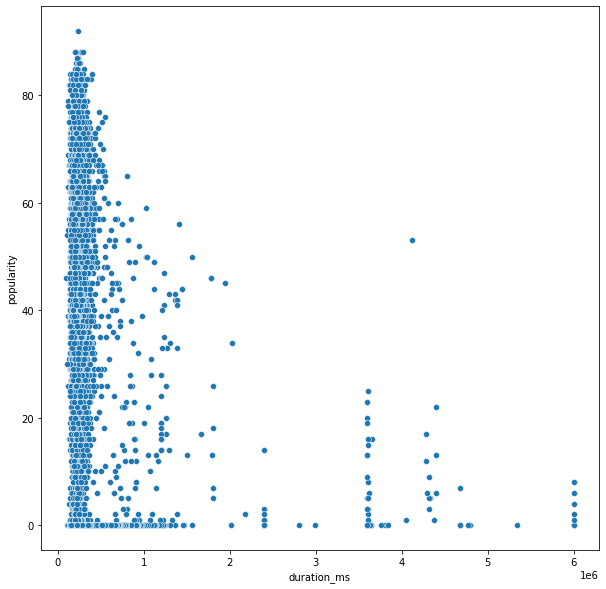

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["duration_ms"],playlist_df["popularity"], ax=ax)
pearsonr(playlist_df["duration_ms"], playlist_df["popularity"])

Then, we thought to do some interesting graphs to correlate some audio features against each other. To see if some song adio features move up or move down with another song audio feature and to what degree.

First, we looked at energy and danceability, and we based this off of intution that there would be some correlation. We also included the Pearson's correlation ratio to measure the possible correlation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.1291088110258407, 2.7381199192989936e-38)

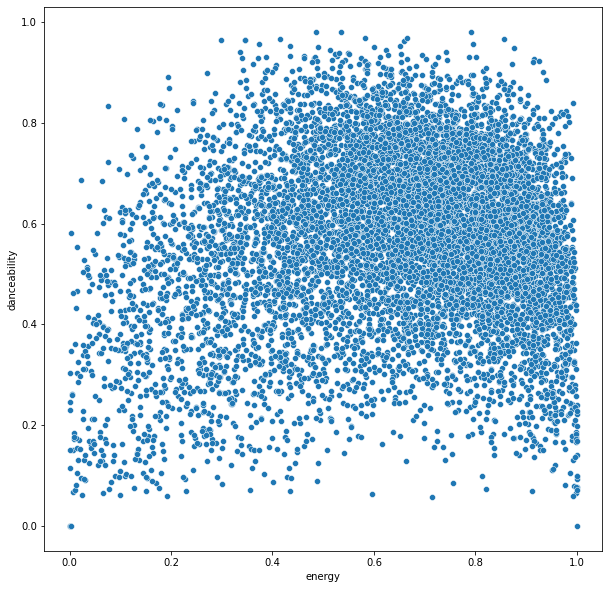

In [44]:
ig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["energy"],playlist_df["danceability"])
pearsonr(playlist_df["energy"], playlist_df["danceability"])

Then, we plot the valence of the songs and song danceability to see if there is any correlation. We also print out the Pearson correlation ratio to put into numbers the graphical representation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.5190488442126701, 0.0)

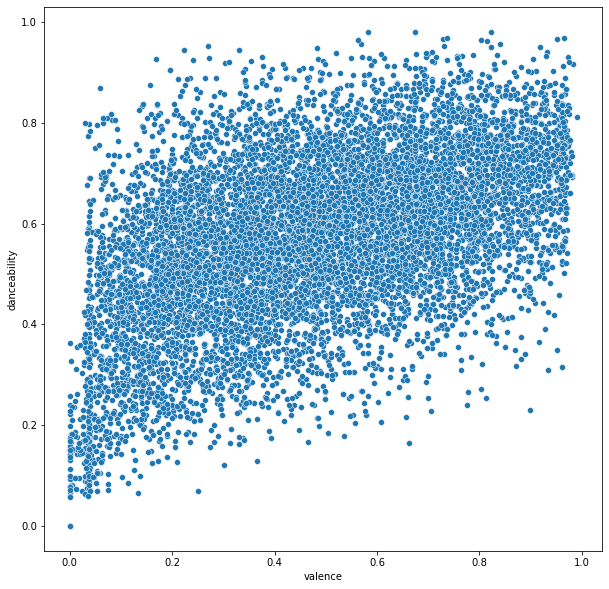

In [45]:
ig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["valence"],playlist_df["danceability"])
pearsonr(playlist_df["valence"], playlist_df["danceability"])

Then, we looked at energy and loudness, and we based this off of intution that there would be some correlation. We also included the Pearson's correlation ratio to measure the possible correlation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.7050732570742995, 0.0)

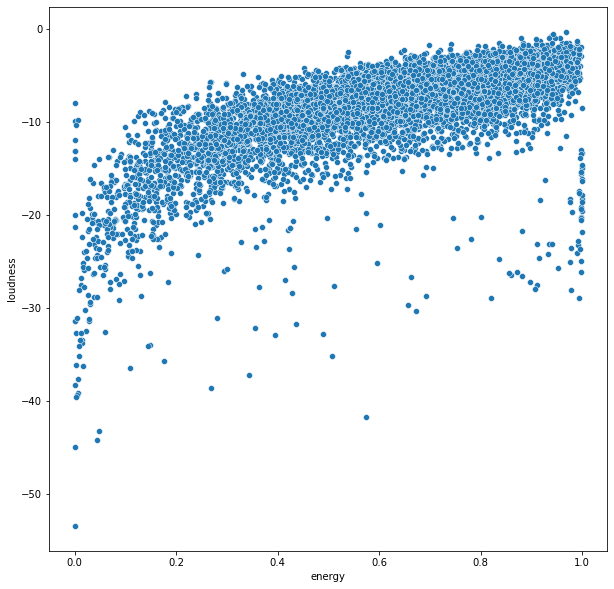

In [46]:
ig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["energy"],playlist_df["loudness"])
pearsonr(playlist_df["energy"], playlist_df["loudness"])

Then, we looked at speechiness and instrumentalness, and we based this off of intution that there would be a negative correlation. We also included the Pearson's correlation ratio to measure the possible correlation

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.0017837638629558464, 0.8587182540859715)

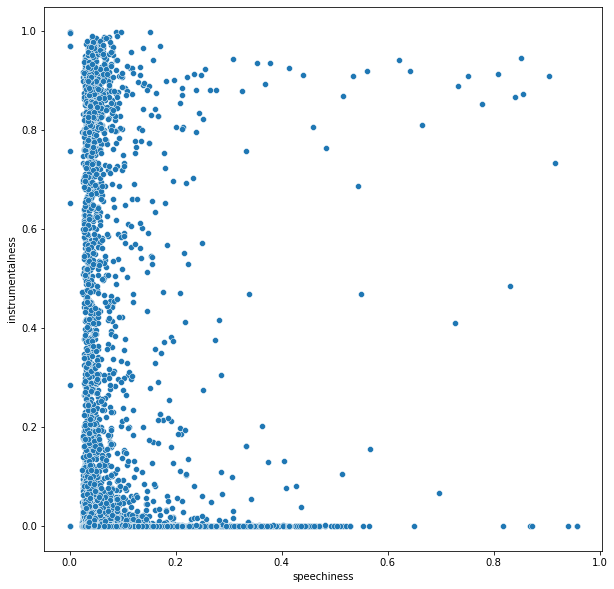

In [47]:
ig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(playlist_df["speechiness"],playlist_df["instrumentalness"])
pearsonr(playlist_df["speechiness"], playlist_df["instrumentalness"])

### More Data Collection & Data Processing

After looking at the distribution of song popularity over our roughly 9,961 song dataset, we realized there were many 0 popularity songs and that would skew our data too much to the right. A bit more than 1/3 of our dataset to be exact.

Our concern was that this would throw off our predictive modeling effectiveness as what we learned was a more normally distributed dataset is more advisable. In any case, more songs **means better modeling**

So to that end, we included a roughly 650 song dataset of the most streamed songs of all-time on Spotify, guessing these songs would have more skewedness to higher popularity. This would give us a fuller, more even and comprehensive dataset.

Similar to other instances, in the interest of ease and not losing API access by going over the daily API query limits, we saved the data into a CSV file for easy and multiple usages later.

The code used to query, collect, and save the data is still included in this notebook, just commented out, for grading purposes.

In [48]:
#This data was re-collected on November 10th and saved to a CSV file for ease and in the interest of not losing API access
#playlist_moststreamed = "2YRe7HRKNRvXdJBp9nXFza"
#user = "Ray Fontaine"

#songs = get_playlist_tracks(user, playlist_moststreamed)
#moststreamed = analyze_playlist(user, playlist_moststreamed, songs)
#moststreamed.to_csv('MostStreamedSongs.csv', encoding='utf-8', index=False)

moststreamed_df = pd.read_csv("MostStreamedSongs.csv")
print("Successfully read CSV file!")

Successfully read CSV file!


We do some explanatory analysis of these new song dataset as well as look to see if it contains any Null/NaN values, and graph its spread or distribution also. 

C:\Users\omarm\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Popularity Distribution')

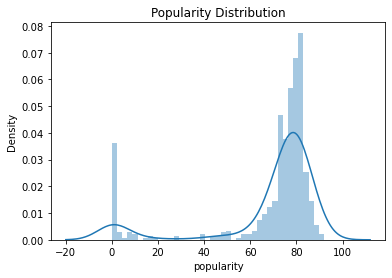

In [49]:
sns.distplot(moststreamed_df['popularity']).set_title('Popularity Distribution')

In [51]:
moststreamed_df.sort_values(by="popularity", ascending=False).head(5)

artist          album       track_name  \
47     The Neighbourhood    I Love You.  Sweater Weather   
125         Harry Styles  Harry's House        As It Was   
1             The Weeknd    After Hours  Blinding Lights   
19            The Weeknd        Starboy          Starboy   
240  J Balvin, Bad Bunny          OASIS       LA CANCIÓN   

                   track_id  release_date  popularity  danceability  energy  \
47   2QjOHCTQ1Jl3zawyYOpxh6          2013          92         0.612   0.807   
125  4Dvkj6JhhA12EX05fT7y2e          2022          91         0.520   0.731   
1    0VjIjW4GlUZAMYd2vXMi3b          2020          90         0.514   0.730   
19   7MXVkk9YMctZqd1Srtv4MB          2016          89         0.679   0.587   
240  0fea68AdmYNygeTGI4RC18          2019          88         0.754   0.646   

     key  loudness  mode  speechiness  instrumentalness  liveness  valence  \
47    10    -2.810     1       0.0336          0.017700    0.1010    0.398   
125    6    -5.338     0       0.0557          0.001010    0.3110    0.662   
1      1    -5.934     1       0.0598          0.000095    0.0897    0.334   
19     7    -7.015     1       0.2760          0.000006    0.1370    0.486   
240    7    -5.795     1       0.3170          0.000018    0.1080    0.429   

       tempo  duration_ms  time_signature  
47   124.053       240400               4  
125  173.930       167303               4  
1    171.005       200040               4  
19   186.003       230453               4  
240  176.089       242573               4

With our supplementary dataset, we see that three of our most popular songs are after 2019, only **three years old**

In [52]:
moststreamed_df.isnull().sum()

artist              0
album               0
track_name          0
track_id            0
release_date        0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

Then we finally combine the two datasets!!

We concatenate the two song datasets, drop any duplicates to avoid any errors in the modeling and analysis, and then print the shape of the final, complete dataset

In [53]:
completesongdataset = pd.concat([playlist_df,moststreamed_df],ignore_index=True)
completesongdataset = completesongdataset.drop_duplicates(keep="first")
completesongdataset.shape

(10320, 18)

But we forgot about the Null/Nan data!!

One instance has carried over from the first song dataset and we must remove it. That's exactly what we do next: 

In [54]:
completesongdataset.isnull().sum()

artist              1
album               1
track_name          1
track_id            0
release_date        0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [55]:
completesongdataset.loc[pd.isnull(completesongdataset.album)]

artist album track_name                track_id  release_date  \
6918    NaN   NaN        NaN  21WB4fVPMcelZNbU5rJkXd             0   

      popularity  danceability  energy  key  loudness  mode  speechiness  \
6918           0         0.277   0.129    5   -23.857     1       0.0607   

      instrumentalness  liveness  valence    tempo  duration_ms  \
6918             0.909     0.175     0.27  118.425       198827   

      time_signature  
6918               4

In [56]:
completesongdataset_without_nan = completesongdataset.dropna()
completesongdataset_without_nan.shape

(10319, 18)

### Modelling 

### Feature Selection

Based on the correlation graphs we did of each song audio feature to popularity, we can decide which ones weigh more importantly than others based off of the Pearson Correlation ratios. Here are the features with the most absolute correlation weight:

1. instrumentalness (0.184)
2. loudness (0.179)
3. valence (0.138)
4. energy (0.120)
5. danceability (0.107)

So we remove all the other independent variables and the dependent variable, our popularity.

In [57]:
X = completesongdataset_without_nan.drop("popularity", axis=1).drop("artist", axis=1).drop("album", axis=1).drop("track_name", axis=1).drop("release_date", axis=1).drop("track_id", axis=1).drop("mode", axis=1).drop("key", axis=1).drop("time_signature", axis=1).drop("speechiness", axis=1).drop("liveness", axis=1).drop("duration_ms", axis=1).drop("tempo", axis=1)
y = completesongdataset_without_nan["popularity"]

### Feature Engineering

Now we need to do some feature engineering. Some of the song audio features are not scaled from 0 to 1 like some of them already are.

So we use a Scaler to do this and then we check to see the values.

In [58]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
names = X.columns
d = scaler.fit_transform(X)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df

danceability  energy  loudness  instrumentalness   valence
0          0.627551   0.779  0.883785          0.000000  0.457576
1          0.701020   0.845  0.922987          0.000000  0.817172
2          0.834694   0.803  0.924643          0.000000  0.638384
3          0.636735   0.876  0.941723          0.000000  0.788889
4          0.626531   0.379  0.808051          0.000464  0.203030
...             ...     ...       ...               ...       ...
10314      0.584694   0.711  0.887284          0.000000  0.474747
10315      0.752041   0.846  0.920354          0.000000  0.551515
10316      0.666327   0.524  0.835591          0.000000  0.558586
10317      0.828571   0.761  0.906960          0.000135  0.347475
10318      0.702041   0.835  0.926900          0.000003  0.888889

[10319 rows x 5 columns]

We then split the variables into Training and Test datasets, with the test dataset being 30% of the full song dataset

In [59]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = 0.3)

### Model 1: Multivariate Linear Regression 

First, we attempt to use a multivariate linear regression model to predict the popularity of the song based on the selected audio features of the songs from the complete, full dataset 

We do this by fitting the X_train and Y_train (training set of the independent and dependent variables respectively) to the model to train it and allow it to do some "machine learning" essentially!

The Multivariate Linear Regression model will take as input the Training set's X values and outputing predicted y values that it will then compare to the training set's y labels. It will use this training set to "learn" the best outputs closest to the y labels.

You can read more about SKlearn's Linear Regression Model [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [60]:
LR = LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

We then attempt to predict the song popularites by inputing the test set of independent variables, X_test

In [61]:
y_prediction =  LR.predict(X_test)

Now, we can assess the accuracy of the Multivariate Linear Regression Model by printing the RMSE (Root Mean Squared Error), which is our Loss Function in this case.

Generally speaking, a lower RMSE score is better and a larger one is worse. Root mean squared error (RMSE) is calculated by the square root of the mean of the square of all of the errors. Similar to the Mean Squared Error (MSE), it punishes for larger errors by doubling them as compare to the Mean Absolute Error (MAE).

You can read more about [RMSE here](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [63]:
#n_estimators = 1000, min_samples_leaf = 2, max_features = 0.35, max_depth=20, random_state = 0
#predicting the accuracy score

score = r2_score(y_test,y_prediction)
print(f'The r2 score is {score}')
print("The RMSE is ", np.sqrt(mean_squared_error(y_test, y_prediction)))

The r2 score is 0.05047243073905061
The RMSE is  28.270282667207105


We see a RMSE score of 28.270 (correct to three decimal places). Which is not good but not exactly that bad either as the smaller it is the better.

Also the R2 score of 0.050 is quite weak but it is acceptable at this moment. Usually the closer the R2 score is to 1, the better.

### Model 2: Random Forest Regression Model

Since we are not completely satisfied with the RMSE score we got with the Multivariate Linear Regression Model, we have decided to use a second model, based on the Random Forest Regressor model by sklearn. You can read more about Random Forest Regression Model [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

We didn't use the default settings on the RandomForestRegressor model, but instead tried to optimize it by:

1. Increasing the total number of Decision Trees used to combine and create the Random Forest model
2. Decrease the maximum number of features considered when looking for the best split. Generally, if max_features is less than the total number of features, then the more general and less overfitted the resulting machine learning model becomes.
3. Setting random state to 0, to control the randomness of the bootstrapping of the samples used when building trees and the sampling of the features to consider when looking for the best split at each node

In [64]:
model_random_forest_specified = RandomForestRegressor(n_estimators = 1000, max_features = 0.35, random_state = 0)

In [65]:
model_random_forest_specified.fit(X_train,y_train)

RandomForestRegressor(max_features=0.35, n_estimators=1000, random_state=0)

In [66]:
print("The R2 score of the Random Forest Model on the training set is ", model_random_forest_specified.score(X_train,y_train))

The R2 score of the Random Forest Model on the training set is  0.8599698569803448


In [67]:
print("The R2 score of the Random Forest Model on the testing set is ", model_random_forest_specified.score(X_test,y_test))

The R2 score of the Random Forest Model on the testing set is  0.02161113563303385


In [68]:
prediction = model_random_forest_specified.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print("The Random Forest Regressor MSE is ", mse)
print("The Random Forest Regressor RMSE is ", rmse)

The Random Forest Regressor MSE is  823.5011766351989
The Random Forest Regressor RMSE is  28.696710205791863


Again the RMSE is similar to the one for the Multivariate Linear Regression Model. We'll try something else but...

Let's see if we can tell the most important features to give weight to in our modeling results

In [69]:
featureImportances = model_random_forest_specified.feature_importances_
featureImportances

array([0.20418743, 0.20450436, 0.21805358, 0.16765835, 0.20559628])

Hmmm...this doesn't help our understanding. Let's try visualizing the feature importances:

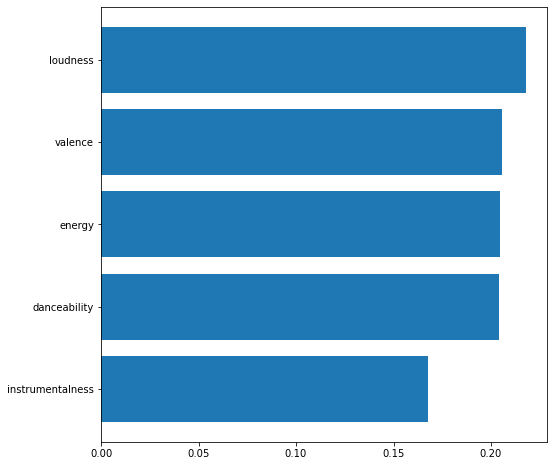

In [71]:
indices = np.argsort(featureImportances)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(range(len(featureImportances)), featureImportances[indices])
ax.set_yticks(range(len(featureImportances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

It seems **Loudness, Valence, then Energy, Danceability, and finally Instrumentalness** are the most important features in that order our Random Forest Regression Model gave weight to after conducting the training sets

### Model 3: Support Vector Regression (SVR) Model

We are still in search of a better model and we will then try the SVM model to see if we can get a lower RMSE score.

So to that end we will use the SVR model, which you can read more about [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [73]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

regr = make_pipeline(SVR(C=1.0, epsilon=0.2))
regr.fit(X_train,y_train)

SVRprediction = regr.predict(X_test)
print("The R2 score of the SVR model is ", regr.score(X_train,y_train))
print("The RMSE score of the SVR model is ", np.sqrt(mean_squared_error(y_test, SVRprediction)))

The R2 score of the SVR model is  0.013546147043684287
The RMSE score of the SVR model is  28.891852046322466


### The Best Model According to RMSE: Multivariate Linear Regression (28.270 RMSE)

### 2nd Best Model According to RMSE: Random Forest Regression (28.697 RMSE)

### Main Findings

So what did **we** learn? The machine learning model certainly learned some...

1. First off, we know that the US music charts dominate the Global music charts. If Massa wants to create a popular song that will dominate the world, he should at least aim to market and target the US music charts for the easiest and shortest path. This means creating a song that will lean into Pop, EDM, or Reggaeton/Trap Latino genres as they are the most popular genres on the Global Chart and US Chart also. However, if he wants to set his sights on the Asian markets, he could easily target both South Korea and Japan as they both share a love for K-pop boy groups and K-pop girl groups. Imagine Massa in a girl group! One genre shared by all charts is standard Pop music, so that is also worth noting.

2. Secondly, we also now know which song audio features are most shared among the US, European, and Asian charts. These audio features most popular and heavily dominating the audio features of songs on chart on all three continents are danceability (range of 0.606 to 0.702) and to a much lesser extent energy (wider range of 0.54 - 0.766). If he wants to dominate the Asian and European charts, he can lean into high energy, high danceability, and high valence tracks.

3. If he/Massa trusts our machine learning models, then he can make a loud track to optimize getting the most out of his popularity index. This is followed by the valence and energy and danceability audio features very closely, which makes sense as we saw that loudness and energy are closely corellated and valence and danceability are similarly closely correlated.

4. Song music features aren't everything! As we can see from the quite large RMSE score of roughly 28, optimizing the audio features of your song can only go so far. We hypothesize that what also plays into popularity is the artist popularity and the level of marketing. Nowadays, viral marketing goes so far; rappers like Doja Cat, Megan Thee Stallion, and singer Pink Pantheress all became stars off of TikTok, not to mention the power of social media in bringing BTS to the forefront. So we could prove a definitive link between the muisc features of a song and its popularity, though we could discern which features played more importance than others and whihc music genres were more popular in which continent.

We are confident these findings will be of importance to someone out there and thank you for reading this far. Remember optimizing success is of importance to all industries.

### Future Work & Limitations 

We advise the following:

1. First, increase the size of the song dataset. We were severely limited by classes interrupting our data collection schedules that would take several hours if we wanted to collect more than 10,000 songs, especially if in the 100,000s like we initially planned and attempted to do several times. We either ran out of time and had to attend class and lose internet connection while commuting or we blew through our query daily limit and lost API access for the day

2. We would include artist popularity in the research model. We found this metric quite late into the data collection process when we were running into quota issues, but it should be an important feature later on. Worth considering total streams to indicate songs that were once popular since the popularity index measure recent popularity.

#### Citation/Credits Appendices

- [1]: https://github.com/juiceblend/spotify-country/blob/master/Playlists.py
- [2]: https://medium.com/@jonahflateman/spotipy-basics-using-the-spotify-web-api-ac9606599bf2
- [3]: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features
- [4]: https://github.com/MaxHilsdorf/introduction_to_spotipy/blob/master/introduction_to_spotipy.ipynb